In [1]:
import os
import pandas as pd
import numpy as np

import pycaret.classification as pc
from pycaret.classification import *

import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient

from sklearn.model_selection import validation_curve, train_test_split
from sklearn import tree  #, preprocessing, metrics, model_selection, linear_model
from sklearn.metrics import log_loss, f1_score, roc_curve

# from urllib.parse import urlparse
# import logging

In [2]:
# Funções Auxiliares

def plot_parameter_validation_curve(X, Y, param_name, grid_search,
                                    model, model_name, scoring,
                                    logx):
    print('Parameter:', param_name)
    print('GridSearch:', grid_search[param_name])
    print('Scoring:', scoring)
    plt.figure(figsize=(6,4))
    train_scores, test_scores = validation_curve(model,
                                                 X = X, 
                                                 y = Y, 
                                                 param_name=param_name, 
                                                 param_range= grid_search[param_name],
                                                 scoring=scoring,
                                                 cv=10,
                                                 n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.title("Curva Validação Modelo " + model_name)
    plt.xlabel(param_name)
    plt.ylabel("Score ("+scoring+")")
    if logx:
        plt.semilogx(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plt.semilogx(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                     color="navy", lw=2)
    else:
        plt.plot(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plt.plot(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                 color="navy", lw=2)
    plt.fill_between(grid_search[param_name], train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=2)
    plt.fill_between(grid_search[param_name], test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=2)
    plt.legend(loc='best')
    plt.grid(True)
 
def plot_parameter_validation_curve_close():    
    plt.show()
    plt.close()


# Funcao que testa a convergencia de um treinamento pela sua curva de aprendizado
def plot_learning_curve(model, model_name, scoring, train_sizes):
    plt.figure(figsize=(6,4))
    ax = plt.gca()
        
    ax.set_title('Curva de Aprendizado (%s)'%model_name)
    ax.set_xlabel("Exemplos do Treino")
    ax.set_ylabel("Score (" + scoring + ")")

    train_sizes, train_scores, test_scores = learning_curve(model,
                                                            X = xtrain,
                                                            y = ytrain,
                                                            cv=cvfold,
                                                            n_jobs=-1,
                                                            train_sizes=train_sizes,
                                                            scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Plot learning curve
    ax.grid()
    ax.plot(train_sizes, train_scores_mean, 'o-', color="darkorange",
                 label="Treino")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="navy",
                 label="Validação-cruzada")
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="darkorange")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="navy")
    ax.legend(loc="best")
    plt.show()

### Configurar MLFlow

In [3]:
# Para usar o sqlite como repositorio

mlflow.set_tracking_uri("sqlite:///mlruns.db")

experiment_name = 'Projeto Black Mamba'

experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment is None:

    experiment_id = mlflow.create_experiment(experiment_name)

    experiment = mlflow.get_experiment(experiment_id)

experiment_id = experiment.experiment_id

2024/04/24 12:32:56 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/04/24 12:32:56 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

### Preparação de Dados

6.a. Os dados devem estar localizados em "/data/raw/dataset_kobe_dev.parquet" e "/data/raw/dataset_kobe_prod.parquet"  

In [4]:
PATH_DATA_RAW = '../data/raw/'

PATH_DATA_PROCESSED = '../data/processed/'

result = os.listdir(PATH_DATA_RAW)

print(f"""os arquivos na pasta raw > {result}""")

os arquivos na pasta raw > ['dataset_kobe_dev.parquet', 'dataset_kobe_prod.parquet']


6.b. Observe que há dados faltantes na base de dados! As linhas que possuem dados faltantes devem ser desconsideradas. Para esse exercício serão apenas consideradas as colunas:  
* lat 
* lng 
* minutes remaining 
* period 
* playoffs 
* shot_distance

In [5]:
data_cols = ['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance', 'shot_made_flag']

COL_TARGET = data_cols[-1]      # 'shot_made_flag' {'success': 1, 'fail': 0}

COL_FEATURES = data_cols[:-1]   # ['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance']

> Exploração de Dados

In [6]:
PATH_FIG = '../output/fig/'

PATH_DESC = '../output/exploratory/'

PATH_FIG_PAIRPLOT = PATH_FIG + 'pairplot.png'

PATH_FIG_HIST_SHOTMADE = PATH_FIG + 'hist_shotmade.png'

PATH_FIG_HIST_PERIOD_PLAYOFF = PATH_FIG + 'hist_period_playoff.png'

PATH_DESC_BEFORE = PATH_DESC + 'desc_before.html'

PATH_INFO_BEFORE = PATH_DESC + 'info_before.txt'

PATH_DESC_AFTER = PATH_DESC + 'desc_after.html'

PATH_INFO_AFTER = PATH_DESC + 'info_after.txt'

PATH_DESC_NAN_DATA = PATH_DESC + 'desc_nan.html'

PATH_DESC_NUMBER_DATA = PATH_DESC + 'desc_number.html'

FILE_RAW_DEV = PATH_DATA_RAW + 'dataset_kobe_dev.parquet'

# criacao de pipeline
with mlflow.start_run(experiment_id = experiment_id, 
                      run_name = 'AnaliseExploratoriaDados'):

    df_orig = pd.read_parquet(FILE_RAW_DEV)
    
    df_dev = df_orig[data_cols]
                    

    # analise exploratoria de dados antes de tratamento                
    df_dev.describe().to_html(PATH_DESC_BEFORE)

    with open(PATH_INFO_BEFORE, 'w') as file_out:
        df_dev.info(buf=file_out)

    mlflow.log_artifact(PATH_DESC_BEFORE)

    mlflow.log_artifact(PATH_INFO_BEFORE)


    print("DataFrame Shape (Antes):", df_dev.shape)


    # dropna e drop_duplicates
    df_dev.dropna(axis=0, inplace=True)


    print("DataFrame Shape (Apos):", df_dev.shape)

    # analise exploratoria de dados antes de tratamento                
    df_dev.describe().to_html(PATH_DESC_AFTER)

    with open(PATH_INFO_AFTER, 'w') as file_out:
        df_dev.info(buf=file_out)

    mlflow.log_artifact(PATH_DESC_AFTER)

    mlflow.log_artifact(PATH_INFO_AFTER)


    sns.pairplot(df_dev)

    plt.savefig(PATH_FIG_PAIRPLOT, format = 'png')

    mlflow.log_artifact(PATH_FIG_PAIRPLOT)

    
    # alterando tipo de dados
    # utilizando df_aux, pois no treinamento esta dando erro
    # MlflowException: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
    df_aux = df_dev.copy()

    object_data = 'period'

    df_aux[object_data] = df_aux[object_data].astype('object')

    categorical_data = ['playoffs', 'shot_made_flag']

    for col in categorical_data:
        df_aux[col] = df_aux[col].astype('category')


    # descrevendo apos tratamento de tipo de data
    df_aux.describe(include = ['number']).to_html(PATH_DESC_NUMBER_DATA)

    mlflow.log_artifact(PATH_DESC_NUMBER_DATA)

    df_aux.describe(include = ['object', 'category']).to_html(PATH_DESC_NAN_DATA)

    mlflow.log_artifact(PATH_DESC_NAN_DATA)

    plt.close()


    # histograma de dados
    ax = plt.axes()

    sns.countplot(x = "shot_made_flag",
                  data = df_dev,
                  ax = ax,
                  palette=("#ff0000", "#ffff00"))
    
    ax.set_title("Distribution of the Shot Made")

    plt.savefig(PATH_FIG_HIST_SHOTMADE, format = 'png')

    mlflow.log_artifact(PATH_FIG_HIST_SHOTMADE)
   
    plt.close()
    

    fig, ax = plt.subplots(2, figsize = (12, 10))

    for v, i in zip(["period", "playoffs"], range(0, 2)):
        sns.countplot(x = v,
                      hue = "shot_made_flag",
                      data = df_dev,
                      ax = ax[i],
                      palette=("#ff0000", "#ffff00"))
        
        ax[i].set_title(v)

    plt.tight_layout()

    plt.savefig(PATH_FIG_HIST_PERIOD_PLAYOFF, format = 'png')

    mlflow.log_artifact(PATH_FIG_HIST_PERIOD_PLAYOFF)

    plt.close()
    


DataFrame Shape (Antes): (24271, 7)
DataFrame Shape (Apos): (20285, 7)


> Pipeline de processamento de dados com o MLFlow

In [7]:
# definicao de nomes dos arquivos
FILE_RAW_DEV = PATH_DATA_RAW + 'dataset_kobe_dev.parquet'

FILE_PROCESSED_FILTERED = PATH_DATA_PROCESSED + 'data_filtered.parquet'

FILE_PROCESSED_TRAIN = PATH_DATA_PROCESSED + 'base_train.parquet'

FILE_PROCESSED_TEST = PATH_DATA_PROCESSED + 'base_test.parquet'


# divisão de dados para o traino
TRAIN_PERC = 0.8


# criacao de pipeline
with mlflow.start_run(experiment_id = experiment_id, 
                      run_name = 'PreparacaoDados'):
    # migrei para analise exploratoria de dados
    # df_dev = pd.read_parquet(FILE_RAW_DEV)
    # df_dev.info()

    # # dropna e drop_duplicates
    # df_dev.dropna(axis=0, inplace=True)
    # df_dev.drop_duplicates(inplace=True)
    # df_dev = df_dev[data_cols].copy()
    # print("DataFrame Shape:", df_dev.shape)
    
    df_dev.to_parquet(FILE_PROCESSED_FILTERED)
    
    # 6.c. separação dos dados em treino e teste
    x_train, x_test, y_train, y_test = train_test_split(
        df_dev[COL_FEATURES],
        df_dev[COL_TARGET],
        train_size = TRAIN_PERC,
        shuffle = True,
        stratify = df_dev[COL_TARGET],
    )
    
    # armazena os datasets resultantes em "/Data/processed/base_{train|test}.parquet
    x_train[COL_TARGET] = y_train
    
    x_train.to_parquet(FILE_PROCESSED_TRAIN)
    
    x_test[COL_TARGET] = y_test
    
    x_test.to_parquet(FILE_PROCESSED_TEST)

    # 6.d. registrando os dados (tracking)
    mlflow.log_params({
        'perc_test': 1 - TRAIN_PERC,
        'filtered_cols': data_cols,
    })
    
    mlflow.log_metrics({
        'qtt_train_rows': x_train.shape[0],
        'qtt_test_rows': x_test.shape[0],
    })

In [ ]:
# >>> para rodar no terminal
# !mlflow ui --backend-store-uri sqlite:///mlruns.db -p 5000

# >>> caso precise encerrar mlflow
# mlflow.end_run()

### Treinamento

,Description,Value
0,Session id,4227
1,Target,shot_made_flag
2,Target type,Binary
3,Original data shape,"(20285, 7)"
4,Transformed data shape,"(20285, 7)"
5,Transformed train set shape,"(16228, 7)"
6,Transformed test set shape,"(4057, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.5368,0.5166,0.5827,0.5131,0.5456,0.0771,0.0778,0.0110
lr,Logistic Regression,0.5755,0.5948,0.4844,0.5645,0.5213,0.1440,0.1453,0.0070


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5484,0.5281,0.6174,0.5230,0.5663,0.1020,0.1036


Parameter: max_depth
GridSearch: [2, 3, 4, 5, 6, 7, 8]
Scoring: f1


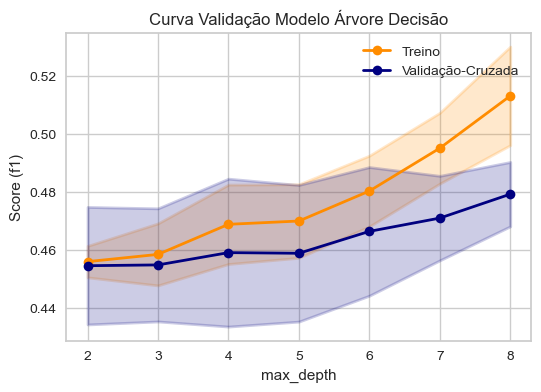

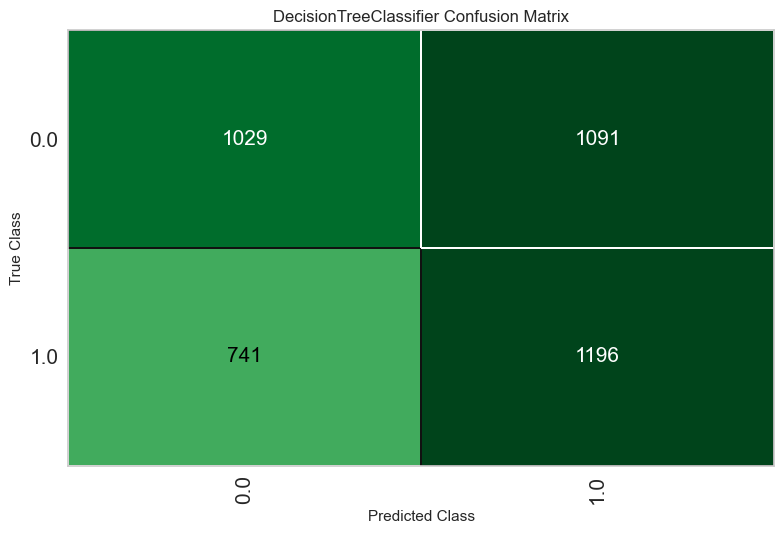

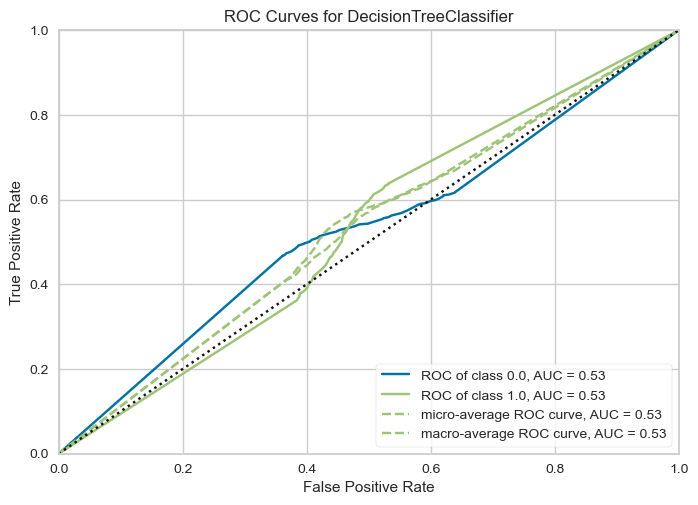

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5839,0.6105,0.4894,0.5756,0.5290,0.1607,0.1624


Parameter: C
GridSearch: [0.001, 0.01, 0.1, 1, 10]
Scoring: f1


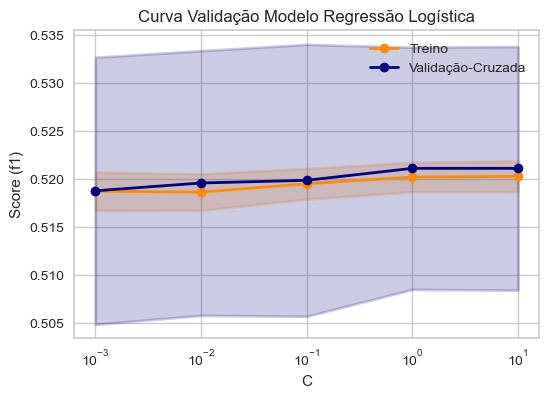

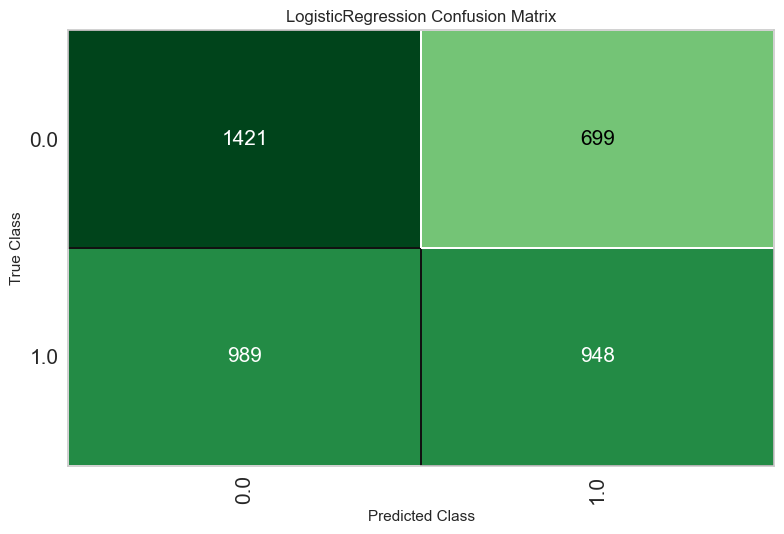

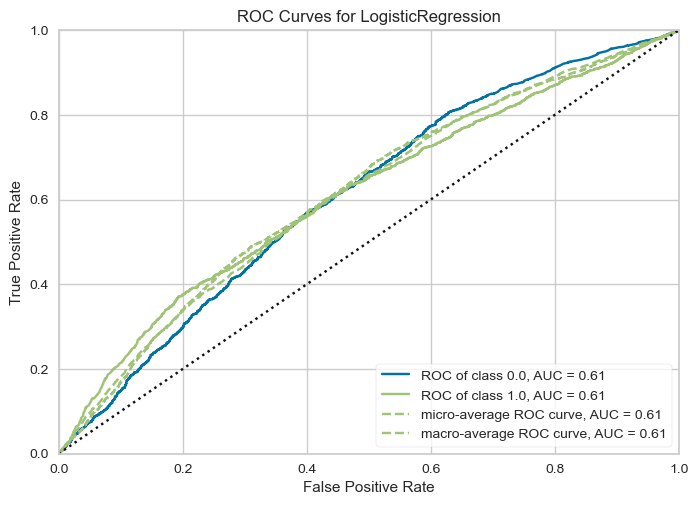

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5484,0.5281,0.6174,0.5230,0.5663,0.1020,0.1036


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5839,0.6105,0.4894,0.5756,0.5290,0.1607,0.1624


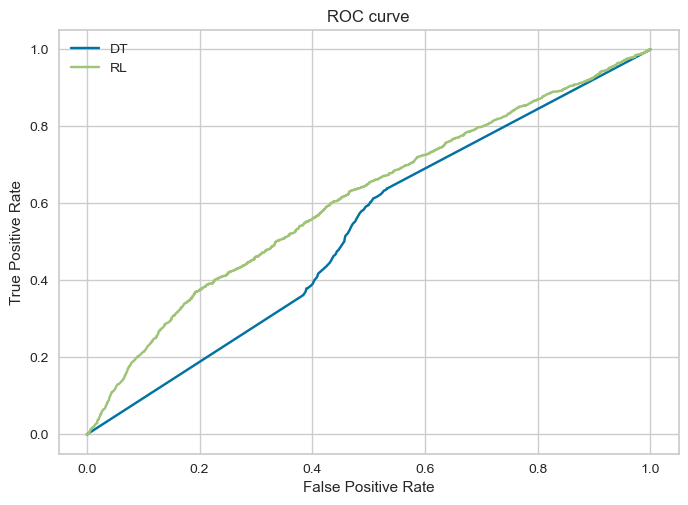

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5896,0.5793,0.3553,0.6222,0.4523,0.1617,0.1779
1,0.6137,0.6039,0.3928,0.6594,0.4923,0.2116,0.2302
2,0.5872,0.5767,0.3432,0.6230,0.4426,0.1564,0.1740
3,0.5792,0.5684,0.3290,0.6100,0.4275,0.1396,0.1563
4,0.5823,0.5727,0.3600,0.6052,0.4515,0.1480,0.1610
5,0.5964,0.5865,0.3665,0.6339,0.4644,0.1763,0.1934
6,0.5835,0.5732,0.3445,0.6138,0.4413,0.1492,0.1651
7,0.6001,0.5909,0.3858,0.6335,0.4796,0.1849,0.2000
8,0.5869,0.5763,0.3437,0.6215,0.4426,0.1557,0.1730


Fitting 10 folds for each of 4 candidates, totalling 40 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5484,0.5281,0.6174,0.5230,0.5663,0.1020,0.1036


Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


Registered model 'modelo_kobe' already exists. Creating a new version of this model...
Created version '4' of model 'modelo_kobe'.


In [26]:
# definicao de nomes dos arquivos
FILE_PROCESSED_PREDICTION_TEST = PATH_DATA_PROCESSED + 'prediction_test.parquet'

FILE_FIG_LR = PATH_FIG + 'lr_validation_curve.png'

FILE_FIG_DT = PATH_FIG + 'dt_validation_curve.png'

FILE_REGISTERED_MODEL = 'modelo_kobe'


nexamples = 5

model_version = -1 # recuperar a ultima versao


with mlflow.start_run(experiment_id = experiment_id, 
                      run_name = 'Treinamento'):

    experiment = pc.setup(
        data = x_train,
        target = COL_TARGET,
        test_data = x_test,
        normalize=True,
        log_experiment=False,
    )
    
    list_models = experiment.compare_models(
        include = ['lr', 'dt'], 
        n_select = 2, 
        sort='f1',
    )

    list_models
        
    
    ## ARVORE DE DECISÃO (DT - DECISION TREE)
    model_0 = list_models[0]

    yhat_test = experiment.predict_model(model_0, 
                                         raw_score = True)

    plot_parameter_validation_curve(
        x_train[COL_FEATURES], # .drop(COL_TARGET, axis=1), 
        y_train, 
        'max_depth', 
        {'max_depth': [x for x in range(2,9)]}, 
        model_0, 
        'Árvore Decisão', 
        'f1', 
        logx = False,
    )
    
    try:
        os.remove(FILE_FIG_DT)
    except OSError:
        pass

    plt.savefig(FILE_FIG_DT, format="png")

    plot_parameter_validation_curve_close()

    mlflow.log_artifact(FILE_FIG_DT)
    
    mlflow.log_metrics({
        'dt_log_loss': log_loss(
            yhat_test[COL_TARGET],
            yhat_test.prediction_label,
        ),
        'dt_f1': f1_score(
            yhat_test[COL_TARGET],
            yhat_test.prediction_label),
    })


    # confusion matrix
    plot_model(model_0, plot = 'confusion_matrix')

    # curva ROC
    plot_model(model_0, plot = 'auc')

    # medindo o modelo
    evaluate_model(model_0)


    ## REGRESSÃO LOGISTICA (LG - LOGISTIC REGRESSION)
    model_1 = list_models[1]

    yhat_test = experiment.predict_model(model_1, 
                                         raw_score = True)

    plot_parameter_validation_curve(
        x_train[COL_FEATURES], # .drop(COL_TARGET, axis=1),
        y_train,
        'C',
        {'C': [0.001, 0.01, 0.1, 1, 10]},
        model_1,
        'Regressão Logística',
        'f1',
        logx = True,
    )
    
    try:
        os.remove(FILE_FIG_LR)
    except OSError:
        pass

    plt.savefig(FILE_FIG_LR, format="png")

    plot_parameter_validation_curve_close()
    
    mlflow.log_artifact(FILE_FIG_LR)

    mlflow.log_metrics({
        'lr_log_loss': log_loss(
            yhat_test[COL_TARGET],
            yhat_test.prediction_label,
        ),
        'lf_f1': f1_score(
            yhat_test[COL_TARGET],
            yhat_test.prediction_label),
    })

   
    # confusion matrix
    plot_model(model_1, plot = 'confusion_matrix')

    # curva ROC
    plot_model(model_1, plot = 'auc')

    # medindo o modelo
    evaluate_model(model_1)



    # curva ROC sobreposta
    yhat_test = experiment.predict_model(model_0, raw_score = True)
    fpr, tpr, thr = roc_curve(yhat_test[COL_TARGET], yhat_test.prediction_score_1)
    plt.plot(fpr, tpr, label = 'DT')

    yhat_test = experiment.predict_model(model_1, raw_score = True)
    fpr, tpr, thr = roc_curve(yhat_test[COL_TARGET], yhat_test.prediction_score_1)
    plt.plot(fpr, tpr, label = 'RL')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.legend()
    plt.title('ROC curve')

    plt.show()


    ## FINALIZACAO MELHOR MODELO
    tune_model = experiment.tune_model(
        model_0,
        optimize = 'f1',
        search_library = 'scikit-learn',
        search_algorithm = 'random',
        n_iter = 4,
    )

    yhat_test = experiment.predict_model(tune_model, 
                                         raw_score=True)


    yhat_test.to_parquet(FILE_PROCESSED_PREDICTION_TEST)
    
    mlflow.log_artifact(FILE_PROCESSED_PREDICTION_TEST)


    mlflow.log_metrics({
        'final_log_loss': log_loss(
            yhat_test[COL_TARGET],
            yhat_test.prediction_label,
        ),
        'final_f1': f1_score(
            yhat_test[COL_TARGET],
            yhat_test.prediction_label),
    })
    
    final_model = experiment.finalize_model(tune_model)


    ## EXPORTACAO PARA LOG E REGISTRO DO MODELO
    experiment.save_model(final_model, f'{FILE_REGISTERED_MODEL}') 
    
    # Carrega novamente o pipeline + bestmodel
    model_pipe = experiment.load_model(f'{FILE_REGISTERED_MODEL}')
    
    # Assinatura do Modelo Inferida pelo MLFlow
    model_features = list(x_train.drop(COL_TARGET, axis=1).columns)

    inf_signature = infer_signature(
        x_train[COL_FEATURES], 
        model_pipe.predict_proba(x_train[COL_FEATURES]) # .drop(COL_TARGET, axis=1))
    )
    
    # Exemplo de entrada para o MLmodel
    input_example = {x: x_train[x].values[:nexamples] for x in COL_FEATURES}
    
    # Log do pipeline de modelagem do sklearn e registrar como uma nova versao
    mlflow.sklearn.log_model(
        sk_model = model_pipe,
        artifact_path = "sklearn-model",
        registered_model_name = FILE_REGISTERED_MODEL,
        signature = inf_signature,
        input_example = input_example,
        pyfunc_predict_fn = 'predict_proba',
    )
    
    # Criacao do cliente do servico MLFlow e atualizacao versao modelo
    client = MlflowClient()

    if model_version == -1:
        model_version = client.get_latest_versions(FILE_REGISTERED_MODEL)[-1].version

    # Registrar o modelo como staging
    client.set_registered_model_alias(
        name    = FILE_REGISTERED_MODEL, 
        alias   = "staging", 
        version = model_version
    )


### Aplicação

In [36]:
data_prod[COL_FEATURES].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5412 entries, 10 to 30695
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lat                5412 non-null   float64
 1   lon                5412 non-null   float64
 2   minutes_remaining  5412 non-null   int64  
 3   period             5412 non-null   int64  
 4   playoffs           5412 non-null   int64  
 5   shot_distance      5412 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 296.0 KB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6426 entries, 10 to 30695
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lat                6426 non-null   float64
 1   lon                6426 non-null   float64
 2   minutes_remaining  6426 non-null   int64  
 3   period             6426 non-null   int64  
 4   playoffs           6426 non-null   int64  
 5   shot_distance      6426 non-null   int64  
 6   shot_made_flag     5412 non-null   float64
dtypes: float64(3), int64(4)
memory usage: 401.6 KB


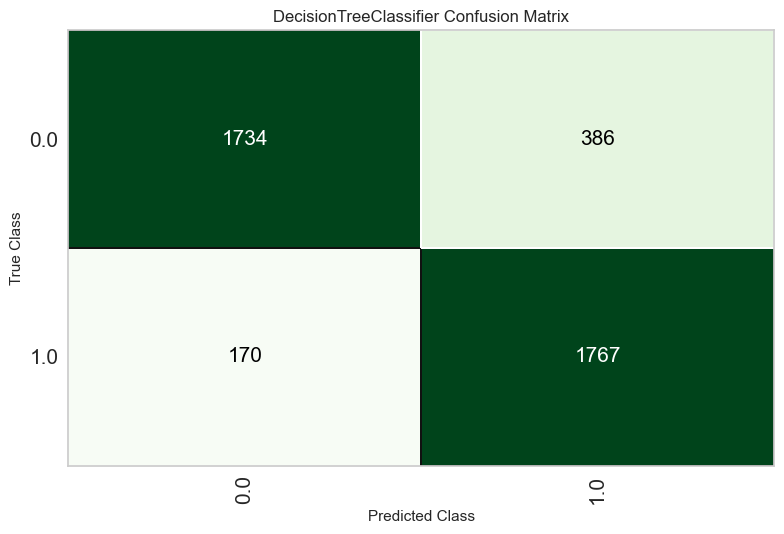

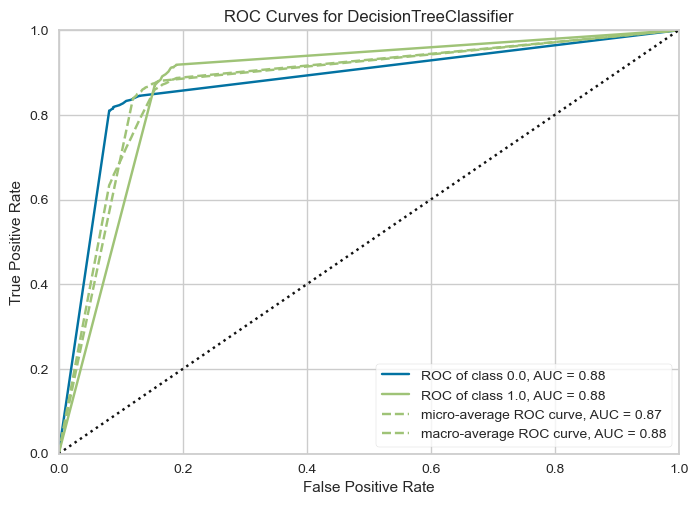

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [33]:
# definicao de nomes dos arquivos
FILE_RAW_PROD = PATH_DATA_RAW + 'dataset_kobe_prod.parquet'

FILE_PROCESSED_PREDICTION_PROD = PATH_DATA_PROCESSED + 'prediction_prod.parquet'


with mlflow.start_run(experiment_id=experiment_id, run_name = 'PipelineAplicacao'):

    model_uri = f"models:/{FILE_REGISTERED_MODEL}@staging"
    
    loaded_model = mlflow.sklearn.load_model(model_uri)
    
    data_prod_orig = pd.read_parquet(FILE_RAW_PROD)
        
    data_prod = data_prod_orig[data_cols]
                    

    # analise exploratoria de dados antes de tratamento                
    data_prod.info()


    # dropna 
    data_prod.dropna(axis=0, inplace=True)


    Y = loaded_model.predict_proba(data_prod[COL_FEATURES])[:,1]
    

    data_prod['predict_score'] = Y

    # confusion matrix
    plot_model(loaded_model, plot = 'confusion_matrix')

    # curva ROC
    plot_model(loaded_model, plot = 'auc')


    # medindo o modelo
    evaluate_model(loaded_model)


    # # salvar o dataset
    data_prod.to_parquet(FILE_PROCESSED_PREDICTION_PROD)
    
    mlflow.log_artifact(FILE_PROCESSED_PREDICTION_PROD)
    
    # Y não está gerando a probabilidade
    mlflow.log_metrics({
        'log_loss': log_loss(
            data_prod[COL_TARGET],
            data_prod.predict_score,
        ),
        'f1': f1_score(
            data_prod[COL_TARGET],
            data_prod.predict_score),
    })


In [31]:
pd.DataFrame(Y).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5412 entries, 0 to 5411
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       5412 non-null   float64
 1   1       5412 non-null   float64
dtypes: float64(2)
memory usage: 84.7 KB


In [ ]:
mlflow.end_run()  